In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

torch.Size([1, 1, 28, 28]) tensor([9])
tensor([[[[1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05],
          [1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05],
          [1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05, 1.0000e-05,
           1.

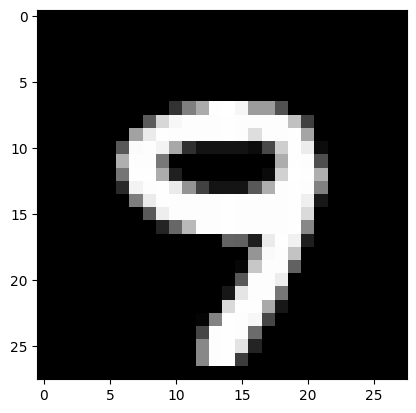

In [2]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

# mnist_train.data.to('cuda')
# mnist_train.targets.to('cuda')
# # mnist_test.data.to('cuda')
# mnist_test.data.to('cuda')
# mnist_test.targets.to('cuda')
# mnist_test.labels
# create a dataloader with
#  batch size 1
mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

In [97]:
temp_x = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.float32)
temp_x[1::3]

tensor([2., 5., 8.])

In [3]:
### Buttom up ####

class SparseLinear(nn.Module):
    def __init__(self, in_features, out_features, branch_factor=2):
        super(SparseLinear, self).__init__()
        self.out_features = out_features
        self.branch_factor = branch_factor
        self.bias = nn.Parameter(nn.init.normal_(torch.empty(out_features//branch_factor, branch_factor)))
        self.activation = nn.LogSoftmax(dim=-1)
        #self.activation = nn.ReLU()
        # self.bias = nn.Parameter(nn.init.normal_(torch.empty(out_features)))
    
    def forward(self, x):
        # print(x.device)
        # print(self.bias.device)
        x = x.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(x.size(0), -1)
        #x = x + self.activation(self.bias).flatten()
        x = x + self.bias.flatten()
        return x

class CobwebSparse(nn.Module):
    def __init__(self, n_layers=3, n_input=784, n_output=False, branch_factor=2):
        super(CobwebSparse, self).__init__()
        self.n_layers = n_layers
        self.n_input = n_input
        self.n_output = n_output
        self.branch_factor = branch_factor
        self.CNN = SimpleCNN()
        
        self.MSE = nn.MSELoss()
        self.activation = nn.LogSoftmax(dim=-1)

        if n_output is not False:
            n_nodes = sum([self.branch_factor ** i for i in range(n_layers)])
            self.decoder = nn.Linear(n_nodes, self.n_output)

        self.encoder = nn.ModuleList(
            [nn.Linear(self.n_input, self.branch_factor ** i, bias=False) for i in range(n_layers)]
        )
        
        self.sparse_layers = nn.ModuleList(
            [SparseLinear(self.branch_factor ** i, self.branch_factor ** (i + 1), self.branch_factor) for i in range(n_layers - 1)]
        )

    def forward(self, x):
        layer_outputs = []
        entropy_loss = 0
        loss = 0

        # x = x.view(x.shape[0], -1)
        x = self.CNN(x)

        z = torch.zeros((x.shape[0], 1), device=x.device)
        
        for i in range(self.n_layers):
            if i > 0:
                parent_activation = self.sparse_layers[i-1](z)
                z = parent_activation

            z += self.encoder[i](x)
            layer_outputs.append(z)
            z = self.activation(z)

        z_children = z

        for i in range(self.n_layers-1):

            child_log_counts = torch.logsumexp(z_children, dim=0)
            p_of_child = torch.softmax(child_log_counts, dim=0)
            p_of_child_given_x = torch.exp(z_children - child_log_counts.unsqueeze(0).expand(z_children.shape[0], z_children.shape[1])).unsqueeze(2).expand(z_children.shape[0], z_children.shape[1], x.shape[1])
            x_children = (x.unsqueeze(1).expand(z_children.shape[0], z_children.shape[1], x.shape[1]) * p_of_child_given_x)
            child_centroids = x_children.sum(0)

            z_parent = torch.logsumexp(z_children.reshape(z_children.shape[0], z_children.shape[1]//self.branch_factor, self.branch_factor), dim=2)
            parent_log_counts = torch.logsumexp(z_parent, dim=0)
            p_of_parent_given_x = torch.exp(z_parent - parent_log_counts.unsqueeze(0).expand(z_parent.shape[0], z_parent.shape[1])).unsqueeze(2).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1])
            x_parent = (x.unsqueeze(1).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1]) * p_of_parent_given_x)
            parent_centroids = x_parent.sum(0)

            sq_errors = torch.pow(x.unsqueeze(1) - parent_centroids.unsqueeze(0), 2) * p_of_parent_given_x
            variances = sq_errors.sum(0)

            parent_centroids = parent_centroids.unsqueeze(1).expand(parent_centroids.shape[0], self.branch_factor, parent_centroids.shape[1]).reshape(parent_centroids.shape[0]*self.branch_factor, parent_centroids.shape[1])
            parent_variances = variances.unsqueeze(1).expand(variances.shape[0], self.branch_factor, variances.shape[1]).reshape(variances.shape[0]*self.branch_factor, variances.shape[1])
    
            KL = torch.pow(parent_centroids - child_centroids, 2)/(2 * (parent_variances+1e-5))    
            # KL = torch.pow(parent_centroids - child_centroids, 2)/2
            entropy_loss -= (p_of_child * KL.sum(1)).sum()
            # print(entropy_loss)

            z_children = z_parent

        # print(type(entropy_loss))

        loss = entropy_loss

        return untils.ModelOutput(loss=loss, 
                                  layer_outputs=layer_outputs,
                                  x=x,
                                  )

        # return loss, layer_outputs

In [4]:
class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        
        self.p_c = nn.Parameter(nn.init.normal_(torch.empty(out_features//branch_factor, branch_factor))) # might do log softmax?
        self.p_x_given_c = nn.Linear(n_hidden, out_features, bias=True)
        # self.p_c = nn.Sequential(
        #     nn.Linear(out_features//branch_factor, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        # self.p_x_given_c = nn.Sequential(
        #     nn.Linear(n_hidden, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, z):
        # z_expanded = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)
        z = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)

        p_c = z + self.p_c.flatten()
        # p_c = z_expanded + self.p_c(z)
        p_x_given_c = self.p_x_given_c(x)

        z = p_x_given_c + p_c
        z = self.logsoftmax(z)
        return x, z
    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(64, 64, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)
    


class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, supervised=False, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning
        self.supervised = supervised

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()

        if self.supervised:
            self.ce_loss = nn.CrossEntropyLoss()
            self.classifier = nn.Linear(branch_factor ** n_layers, n_classes)

    def layer_KL_loss(self, x, z):
        cluster_mass = torch.logsumexp(z, dim=0) # shape: (out_features,)
        p_clusters = torch.softmax(cluster_mass, dim=0)

        p_of_batch_given_clusters = torch.exp(z - cluster_mass.unsqueeze(0).expand(z.shape[0], -1)).unsqueeze(2).expand(z.shape[0], z.shape[1], x.shape[1])
        # shape: (batch_size, out_features, n_hidden)
        cluster_centorids = (x.unsqueeze(1).expand(z.shape[0], z.shape[1], x.shape[1]) * p_of_batch_given_clusters).sum(dim=0)
        # print(f"p(b|c): {p_of_batch_given_clusters}", p_of_batch_given_clusters.shape)
        # shape: (out_features, n_hidden)

        # reconstruct the parent centroid
        # by defning the parent mass is the sum of the child mass
        z_parent = torch.logsumexp(z.reshape(z.shape[0], -1, self.branch_factor), dim=2)
        # print(f"z_parent: {z_parent}")
        parent_cluster_mass = torch.logsumexp(z_parent, dim=0)
        # print(f"parent_cluster_mass: {parent_cluster_mass}")
        p_of_batch_given_parent_clusters = torch.exp(z_parent - parent_cluster_mass.unsqueeze(0).expand(z_parent.shape[0], -1)).unsqueeze(2).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1])
        parent_cluster_centorids = (x.unsqueeze(1).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1]) * p_of_batch_given_parent_clusters).sum(dim=0)
        # print(f"p(b|p): {p_of_batch_given_parent_clusters}", p_of_batch_given_parent_clusters.shape)

        # calculate the KL divergence
        parent_cluster_centorids = parent_cluster_centorids.unsqueeze(1).expand(parent_cluster_centorids.shape[0], self.branch_factor, parent_cluster_centorids.shape[1]).reshape(-1, parent_cluster_centorids.shape[1])
        KL_loss = torch.pow(parent_cluster_centorids - cluster_centorids, 2).sum(dim=1) * p_clusters
        KL_loss = KL_loss.sum()

        return KL_loss

    def forward(self, x, y=None):
        layer_outputs = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)
        # print(x.shape)
        # x = self.CNN(x)
        # print(f"range of x: {x.min()}, {x.max()}")
        z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        KL_loss = 0
        for layer in self.layers:
            # print(f"parent z: {z}")
            # convert to probs
            # print(f"parent activatoin (probabilities): {torch.exp(z)}\n")
            x, z = layer(x, z)
            # print(f"child z: {z}")
            # print(f"child activatoin (probabilities): {torch.exp(z)}\n")
            # print(f"range of z: {z.min()}, {z.max()}")
            layer_outputs.append(z)

            # print(z.shape)

            KL_loss -= self.layer_KL_loss(x, z)
        loss += KL_loss

        logits = None
        if self.supervised:
            logits = self.classifier(z)
            loss += self.ce_loss(logits, y)
            # pass
        # loss = KL_loss

        return untils.ModelOutput(loss=loss, layer_outputs=layer_outputs, x=x, 
                                  logits=logits)


In [41]:
# New version
class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        
        self.p_c = nn.Parameter(nn.init.normal_(torch.empty(out_features//branch_factor, branch_factor))) # might do log softmax?
        self.p_x_given_c = nn.Linear(n_hidden, out_features, bias=True)
        # self.p_c = nn.Sequential(
        #     nn.Linear(out_features//branch_factor, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        # self.p_x_given_c = nn.Sequential(
        #     nn.Linear(n_hidden, out_features),
        #     # nn.ReLU(),
        #     nn.Tanh(),
        #     nn.Linear(out_features, out_features, bias=True),
        #     # nn.LogSoftmax(dim=1)
        # )

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, z):
        '''
        z: parent z (current)
        '''
        B = x.size(0)

        # z_expanded = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)
        z = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1) # change shape from (batch_size, in_features) to (batch_size, branch_factor * in_features)
        p_x_given_c = self.p_x_given_c(x)
        p_x_given_c = self.logsoftmax(p_x_given_c.view(B, -1, self.branch_factor)).view(B, -1) # softmax every branch_factor elements
        z = z + p_x_given_c


        # p_c = z + self.p_c.flatten()
        # p_c = z_expanded + self.p_c(z)
        # p_x_given_c = self.p_x_given_c(x)

        # z = p_x_given_c + p_c
        # z = self.logsoftmax(z)
        return x, z
    
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(64, 64, 3),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        # return self.sigmoid(x.view(x.size(0), -1))
        return x.view(x.size(0), -1)
    


class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, supervised=False, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning
        self.supervised = supervised

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()

        if self.supervised:
            self.ce_loss = nn.CrossEntropyLoss()
            self.classifier = nn.Linear(branch_factor ** n_layers, n_classes)

    def layer_KL_loss(self, x, z):
        cluster_mass = torch.logsumexp(z, dim=0) # shape: (out_features,)
        p_clusters = torch.softmax(cluster_mass, dim=0)

        p_of_batch_given_clusters = torch.exp(z - cluster_mass.unsqueeze(0).expand(z.shape[0], -1)).unsqueeze(2).expand(z.shape[0], z.shape[1], x.shape[1])
        # shape: (batch_size, out_features, n_hidden)
        cluster_centorids = (x.unsqueeze(1).expand(z.shape[0], z.shape[1], x.shape[1]) * p_of_batch_given_clusters).sum(dim=0)
        # print(f"p(b|c): {p_of_batch_given_clusters}", p_of_batch_given_clusters.shape)
        # shape: (out_features, n_hidden)

        # reconstruct the parent centroid
        # by defning the parent mass is the sum of the child mass
        z_parent = torch.logsumexp(z.reshape(z.shape[0], -1, self.branch_factor), dim=2)
        # print(f"z_parent: {z_parent}")
        parent_cluster_mass = torch.logsumexp(z_parent, dim=0)
        # print(f"parent_cluster_mass: {parent_cluster_mass}")
        p_of_batch_given_parent_clusters = torch.exp(z_parent - parent_cluster_mass.unsqueeze(0).expand(z_parent.shape[0], -1)).unsqueeze(2).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1])
        parent_cluster_centorids = (x.unsqueeze(1).expand(z_parent.shape[0], z_parent.shape[1], x.shape[1]) * p_of_batch_given_parent_clusters).sum(dim=0)
        # print(f"p(b|p): {p_of_batch_given_parent_clusters}", p_of_batch_given_parent_clusters.shape)

        # calculate the KL divergence
        parent_cluster_centorids = parent_cluster_centorids.unsqueeze(1).expand(parent_cluster_centorids.shape[0], self.branch_factor, parent_cluster_centorids.shape[1]).reshape(-1, parent_cluster_centorids.shape[1])

        # print(f"parent_cluster_centorids: {parent_cluster_centorids.shape}")
        # print(f"cluster_centorids: {cluster_centorids.shape}")
        KL_loss = torch.pow(parent_cluster_centorids - cluster_centorids, 2).sum(dim=1) * p_clusters
        KL_loss = KL_loss.sum()

        return KL_loss, cluster_centorids, parent_cluster_centorids
    
    def triplet_loss(self, x, parent_z, childrent_z):
        '''
        parent_z shape: (batch_size, n_clusters)
        childrent_z shape: (batch_size, n_clusters * branch_factor)
        '''
        # step 1, find out the centroids
        parent_centroids = torch.exp(parent_z.unsqueeze(-1) + torch.log(x).unsqueeze(1)).mean(dim=0) # shape: (n_clusters, n_hidden)
        childrent_centroids = torch.exp(childrent_z.unsqueeze(-1) + torch.log(x).unsqueeze(1)).mean(dim=0) # shape: (n_clusters * branch_factor, n_hidden)
        child_1_centroids = childrent_centroids[::2]
        child_2_centroids = childrent_centroids[1::2]

        # step 2, calculate the mse
        ## chidlren-children mse
        # childrent_mse = torch.pow(child_1_centroids - child_2_centroids, 2).sum(dim=1).mean()
        ## parent-children mse
        parent_mse = torch.pow(parent_centroids - child_1_centroids, 2).sum(dim=1).mean() #+ \
                        #torch.pow(parent_centroids - child_2_centroids, 2).sum(dim=1).mean()

        ## parent-children mse
        
        print(f"parent_mse: {parent_mse}")
        # print(f"childrent_mse: {childrent_mse}")
        
        alpha = -1
        beta = 1
        return alpha * parent_mse
        


        # print(f"parent_centroids: {parent_centroids}")
        # print(f"childrent_centroids: {childrent_centroids}")
        # print(f"parent_z: {parent_z}")
        # print(f"childrent_z: {childrent_z}")
        # print(f"x: {x}")

    def forward(self, x, y=None):
        layer_outputs = []
        parent_cluster_centorids = []
        child1_cluster_centorids = []
        child2_cluster_centorids = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)
        # print(x.shape)
        # x = self.CNN(x)
        # print(f"range of x: {x.min()}, {x.max()}")
        parent_z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        KL_loss = 0
        for i, layer in enumerate(self.layers):
            # print(f"parent z: {z}")
            # convert to probs
            # print(f"parent activatoin (probabilities): {torch.exp(z)}\n")
            x, children_z = layer(x, parent_z)
            # print(f"child z: {z}")
            # print(f"child activatoin (probabilities): {torch.exp(z)}\n")
            # print(f"range of z: {z.min()}, {z.max()}")
            layer_outputs.append(children_z)
            # print(f"layer {i}: {children_z}")

            # print(f"layer {i}: {z}")
            # print(f'Expontial: {torch.exp(z)}\n')
            # loss_output, cluster_centorid, parent_cluster_centorid = self.layer_KL_loss(x, children_z)
            triplet_loss = self.triplet_loss(x, parent_z, children_z)
            parent_z = children_z
            loss += triplet_loss
            # loss -= loss_output

            # parent_cluster_centorids.append(parent_cluster_centorid[0])
            # child1_cluster_centorids.append(cluster_centorid[0])
            # child2_cluster_centorids.append(cluster_centorid[1])

            # KL_loss -= triplet_loss
        # loss = KL_loss

        logits = None
        if self.supervised:
            logits = self.classifier(children_z)
            loss = self.ce_loss(logits, y)
            # pass
        # loss = KL_loss

        debug = {
            'parent_cluster_centorids': parent_cluster_centorids,
            'child1_cluster_centorids': child1_cluster_centorids,
            'child2_cluster_centorids': child2_cluster_centorids
        }

        return untils.ModelOutput(loss=loss, layer_outputs=layer_outputs, x=x, 
                                  logits=logits, debug_info=debug)


In [13]:
## Supervised

class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2, k=10):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        self.n_classes = k
        
        self.p_c_given_x = nn.Linear(n_hidden, out_features, bias=True)
        # self.classifier = nn.Linear(out_features, k, bias=True)
        self.classifier_w = nn.Parameter(torch.randn(out_features, n_hidden, k))
        self.classifier_b = nn.Parameter(torch.randn(out_features, k))

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, z):
        '''
        z: parent z (current)
        '''
        B = x.size(0)

        # z_expanded = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)
        z = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1) # change shape from (batch_size, in_features) to (batch_size, branch_factor * in_features)
        p_c_given_x = self.p_c_given_x(x)
        p_c_given_x = self.logsoftmax(p_c_given_x.view(B, -1, self.branch_factor)).view(B, -1) # softmax every branch_factor elements
        z = z + p_c_given_x # shape: (batch_size, out_features)
        # logits = self.classifier(z) # shape: (batch_size, n_classes)
        # softmax the z on the batch dimension
        p_b_of_c = z - torch.logsumexp(z, dim=0).unsqueeze(0).expand(z.shape[0], z.shape[1]) # shape: (batch_size, out_features)
        weighted_x = torch.exp(p_b_of_c).unsqueeze(2) * x.unsqueeze(1)
        # weighted_x = torch.exp(weighted_x) # shape: (batch_size, out_features, n_hidden)
        # logits = self.classifier(weighted_x)
        logits = torch.einsum('bch,chk->bck', weighted_x, self.classifier_w) + self.classifier_b


        # print(f"z: {z.shape}") 
        # print(f"z: {z}")
        # print(f"exp(z): {torch.exp(z)}")
        # print(f"p_c_given_x: {p_c_given_x}")
        # print(f"exp(p_c_given_x): {torch.exp(p_c_given_x)}")
        # print(f"weighted_x: {weighted_x.shape}")
        # print(f"logits: {logits.shape}")
        # print(f"logits: {logits}")

        logits = logits + z.unsqueeze(-1)
        logits = logits.sum(dim=1)

        return x, z, logits

class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning


        self.cs_loss = nn.CrossEntropyLoss()

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor, k=n_classes) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()


    def forward(self, x, y=None):
        layer_p_c = []
        layer_logits = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)

        parent_z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        for i, layer in enumerate(self.layers):
            x, children_z, pred_logits = layer(x, parent_z)
            layer_p_c.append(children_z)
            layer_logits.append(pred_logits)

            parent_z = children_z

        layer_logits = torch.stack(layer_logits, dim=0)
        layer_logits = layer_logits.sum(dim=0)
        # print(f"layer_logits: {layer_logits.shape}")
        loss = self.cs_loss(layer_logits, y)

        return untils.ModelOutput(loss=loss, layer_outputs=layer_p_c, x=x, logits=layer_logits)


In [ ]:
## Supervised

class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2, k=10):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        self.n_classes = k
        
        self.p_c_given_x = nn.Linear(n_hidden, out_features, bias=True)
        # self.classifier = nn.Linear(out_features, k, bias=True)
        self.classifier_w = nn.Parameter(torch.randn(out_features, n_hidden, k))
        self.classifier_b = nn.Parameter(torch.randn(out_features, k))

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, z):
        '''
        z: parent z (current)
        '''
        B = x.size(0)

        # z_expanded = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1)
        z = z.unsqueeze(2).expand(-1, -1, self.branch_factor).reshape(z.size(0), -1) # change shape from (batch_size, in_features) to (batch_size, branch_factor * in_features)
        p_c_given_x = self.p_c_given_x(x)
        p_c_given_x = self.logsoftmax(p_c_given_x.view(B, -1, self.branch_factor)).view(B, -1) # softmax every branch_factor elements
        z = z + p_c_given_x # shape: (batch_size, out_features)
        # logits = self.classifier(z) # shape: (batch_size, n_classes)
        # softmax the z on the batch dimension
        p_b_of_c = z - torch.logsumexp(z, dim=0).unsqueeze(0).expand(z.shape[0], z.shape[1]) # shape: (batch_size, out_features)
        weighted_x = torch.exp(p_b_of_c).unsqueeze(2) * x.unsqueeze(1)
        # weighted_x = torch.exp(weighted_x) # shape: (batch_size, out_features, n_hidden)
        # logits = self.classifier(weighted_x)
        logits = torch.einsum('bch,chk->bck', weighted_x, self.classifier_w) + self.classifier_b


        # print(f"z: {z.shape}") 
        # print(f"z: {z}")
        # print(f"exp(z): {torch.exp(z)}")
        # print(f"p_c_given_x: {p_c_given_x}")
        # print(f"exp(p_c_given_x): {torch.exp(p_c_given_x)}")
        # print(f"weighted_x: {weighted_x.shape}")
        # print(f"logits: {logits.shape}")
        # print(f"logits: {logits}")

        logits = logits + z.unsqueeze(-1)
        logits = logits.sum(dim=1)

        return x, z, logits

class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning


        self.cs_loss = nn.CrossEntropyLoss()

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor, k=n_classes) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()


    def forward(self, x, y=None):
        layer_p_c = []
        layer_logits = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)

        parent_z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        for i, layer in enumerate(self.layers):
            x, children_z, pred_logits = layer(x, parent_z)
            layer_p_c.append(children_z)
            layer_logits.append(pred_logits)

            parent_z = children_z

        layer_logits = torch.stack(layer_logits, dim=0)
        layer_logits = layer_logits.sum(dim=0)
        # print(f"layer_logits: {layer_logits.shape}")
        loss = self.cs_loss(layer_logits, y)

        return untils.ModelOutput(loss=loss, layer_outputs=layer_p_c, x=x, logits=layer_logits)


In [ ]:
## Supervised

class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2, k=10):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        self.n_classes = k

        self.classifier_w = nn.Parameter(torch.randn(out_features, n_hidden, k))
        self.classifier_b = nn.Parameter(torch.randn(out_features, k))
        
        self.l_prob = nn.Linear(n_hidden, out_features//branch_factor, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, z):
        '''
        z: parent z (current)
        x: shape of (batch_size, n_hidden)
        '''
        B = x.size(0)

        x_l_prob = self.sigmoid(self.l_prob(x)) # shape: (batch_size, out_features//branch_factor)
        x_r_prob = 1 - x_l_prob
        # print(f"x_l_prob: {x_l_prob.shape}")
        # print(f"x_l_prob: {x_l_prob}")

        z_l = z + torch.log(x_l_prob)
        z_r = z + torch.log(x_r_prob)

        z = torch.cat([z_l, z_r], dim=1) # shape: (batch_size, out_features)

        weighted_x_l = z_l.unsqueeze(2) + torch.log(x).unsqueeze(1) # shape: (batch_size, out_features//branch_factor, n_hidden)
        weighted_x_r = z_r.unsqueeze(2) + torch.log(x).unsqueeze(1)

        # concate the two branches via the second dimension
        weighted_x = torch.exp(torch.cat([weighted_x_l, weighted_x_r], dim=1)) # shape: (batch_size, out_features, n_hidden)

        logits = torch.einsum('bch,chk->bck', weighted_x, self.classifier_w) + self.classifier_b # shape: (batch_size, n_cluster, n_classes)
        x_prob = torch.cat([x_l_prob, x_r_prob], dim=1) # shape: (batch_size, n_cluster)
        # weight logits by x_prob
        # print(f"weighted_x: {weighted_x.shape}")
        # print(f"logits: {logits.shape}")
        # print(f"x_prob: {x_prob.shape}")
        logits = logits * x_prob.unsqueeze(-1)
        logits = logits.sum(dim=1)

        # print(f"z: {z.shape}") 
        # print(f"z: {z}")
        # print(f"exp(z): {torch.exp(z)}")
        # print(f"p_c_given_x: {p_c_given_x}")
        # print(f"exp(p_c_given_x): {torch.exp(p_c_given_x)}")
        # print(f"weighted_x: {weighted_x.shape}")
        # print(f"logits: {logits.shape}")
        # print(f"logits: {logits}")

        # logits = logits + z.unsqueeze(-1)
        # logits = logits.sum(dim=1)

        return x, z, logits

class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning


        self.cs_loss = nn.CrossEntropyLoss()

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor, k=n_classes) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()


    def forward(self, x, y=None):
        layer_p_c = []
        layer_logits = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)

        parent_z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        for i, layer in enumerate(self.layers):
            x, children_z, pred_logits = layer(x, parent_z)
            layer_p_c.append(children_z)
            layer_logits.append(pred_logits)

            parent_z = children_z

        layer_logits = torch.stack(layer_logits, dim=0)
        layer_logits = layer_logits.sum(dim=0)
        # print(f"layer_logits: {layer_logits.shape}")
        loss = self.cs_loss(layer_logits, y)

        return untils.ModelOutput(loss=loss, layer_outputs=layer_p_c, x=x, logits=layer_logits)


In [ ]:
## Supervised - with representation learning

class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2, k=10):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        self.n_classes = k

        self.classifier_w = nn.Parameter(torch.randn(out_features, n_hidden, k))
        self.classifier_b = nn.Parameter(torch.randn(out_features, k))
        
        self.l_prob = nn.Linear(n_hidden, out_features//branch_factor, bias=True)

        self.classifer = nn.Linear(n_hidden, k, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, z):
        '''
        z: parent z (current)
        x: shape of (batch_size, n_hidden)
        '''
        B = x.size(0)

        x_l_prob = self.l_prob(x) # shape: (batch_size, out_features//branch_factor)
        x_l_prob = self.sigmoid(x_l_prob) + 1e-6
        # x_r_prob = -x_l_prob + self.sigmoid(x_l_prob)
        # x_l_prob = self.sigmoid(x_l_prob)
        x_r_prob = 1 - x_l_prob + 1e-6
        # print(f"x_l_prob: {x_l_prob.shape}")
        # print(f"x_l_prob: {x_l_prob}")

        z_l = z + torch.log(x_l_prob)
        z_r = z + torch.log(x_r_prob)
        z = torch.cat([z_l, z_r], dim=1) # shape: (batch_size, out_features)

        weighted_x_l = (z_l.unsqueeze(2) + torch.log(x).unsqueeze(1)).sum(dim=0) # shape: (batch_size, out_features//branch_factor, n_hidden)
        weighted_x_r = (z_r.unsqueeze(2) + torch.log(x).unsqueeze(1)).sum(dim=0)

        # concate the two branches via the second dimension
        weighted_x = torch.exp(torch.cat([weighted_x_l, weighted_x_r], dim=0)) # shape: (out_features, n_hidden)
        # print(f"weighted_x: {weighted_x.shape}")
        # logits = self.classifer(weighted_x) # shape: (out_features, n_classes)

        

        # logits = torch.einsum('ch,chk->ck', weighted_x, self.classifier_w) + self.classifier_b # shape: (batch_size, n_cluster, n_classes)
        # x_prob = torch.cat([x_l_prob, x_r_prob], dim=1) # shape: (batch_size, n_cluster)
        # weight logits by x_prob
        # print(f"weighted_x: {weighted_x.shape}")
        # print(f"logits: {logits.shape}")
        # print(f"x_prob: {x_prob.shape}")
        # logits = logits * x_prob.unsqueeze(-1)
        # logits = logits.sum(dim=1)

        # print(f"z: {z.shape}") 
        # print(f"z: {z}")
        # print(f"exp(z): {torch.exp(z)}")
        # print(f"p_c_given_x: {p_c_given_x}")
        # print(f"exp(p_c_given_x): {torch.exp(p_c_given_x)}")
        # print(f"weighted_x: {weighted_x.shape}")
        # print(f"logits: {logits.shape}")
        # print(f"logits: {logits}")

        # logits = logits + z.unsqueeze(-1)
        logits = logits.sum(dim=0)
        print(f"logits: {logits.shape}")

        return x, z, logits

class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning

        self.cs_loss = nn.CrossEntropyLoss()

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor, k=n_classes) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()

        self.classifier = nn.Linear(2 ** (n_layers + 1) - 2, n_classes)


    def forward(self, x, y=None):
        layer_p_c = []
        layer_logits = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)

        parent_z = torch.zeros((x.size(0), 1), device=x.device)

        loss = 0
        for i, layer in enumerate(self.layers):
            x, children_z, pred_logits = layer(x, parent_z)
            layer_p_c.append(children_z)
            layer_logits.append(pred_logits)

            parent_z = children_z

        # concat chidlren_z across second dimension
        all_z = torch.cat(layer_p_c, dim=1)
        # print(all_z.shape)
        # logits = self.classifier(all_z)

        layer_logits = torch.stack(layer_logits, dim=0)
        logits = layer_logits.sum(dim=0)
        
        # print(f"layer_logits: {layer_logits.shape}")
        loss = self.cs_loss(logits, y)

        return untils.ModelOutput(loss=loss, layer_outputs=layer_p_c, x=x, logits=logits)


In [5]:
## Supervised - learning centroids
class CobwebNNTreeLayer(nn.Module):
    '''
    TODO: try more complex approximation of p_c and p_x_given_c
            maybe add non-linearity and more layers to the approximation
    '''
    def __init__(self, n_hidden, out_features, branch_factor=2, k=10):
        super(CobwebNNTreeLayer, self).__init__()
        self.n_hidden = n_hidden
        self.out_features = out_features
        self.branch_factor = branch_factor
        self.n_classes = k

        # self.left_mean = nn.Parameter(torch.randn(out_features//branch_factor, n_hidden))
        # self.left_mean = nn.Parameter(torch.zeros(out_features//branch_factor, n_hidden))
        # radnom between 0 and 1
        self.left_mean = nn.Parameter(torch.rand(out_features//branch_factor, n_hidden))
        self.class_projection = nn.Linear(out_features, k, bias=True)

        self.softmax = nn.Softmax(dim=-1)

        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, x, z, y):
        '''
        z: parent z (current mean)
        x: shape of (batch_size, n_hidden)
        '''
        B = x.size(0)

        # x_l_prob = self.l_prob(x) # shape: (batch_size, out_features//branch_factor)
        # l_mean_dist = x @ self.left_mean.T
        # print(f"l_mean: {self.left_mean.shape}")
        r_mean = 2 * z - self.left_mean
        # print(f"r_mean: {r_mean.shape}")
        

        z = torch.cat([self.left_mean, r_mean], dim=0)
        layer_classes_mean = self.class_projection(z.T).T # from (out_features, n_hidden) to (n_classes, n_hidden)

        class_dist = torch.pow(x.unsqueeze(1) - layer_classes_mean.unsqueeze(0), 2).sum(dim=-1) # shape: (batch_size, n_clusters)
        # class_probs = self.softmax(-class_dist)
        # loss = self.cross_entropy(class_probs, y)

        return x, z, -class_dist

class CobwebNN(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, do_reprerentation_learning=False, n_classes=10):
        super(CobwebNN, self).__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.do_reprerentation_learning = do_reprerentation_learning

        self.ce_loss = nn.CrossEntropyLoss()

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor ** i, branch_factor, k=n_classes) for i in range(1, n_layers + 1)]
        )

        if self.do_reprerentation_learning:
            self.CNN = SimpleCNN()

        self.classifier = nn.Linear(2 ** (n_layers + 1) - 2, n_classes)

        self.root_mean = nn.Parameter(torch.rand(1, n_hidden))


    def forward(self, x, y=None):
        layer_p_c = []
        layer_logits = []

        if self.do_reprerentation_learning:
            x = self.CNN(x)
        else:
            x = x.view(-1, self.n_hidden)

        # parent_z = torch.zeros((1, self.n_hidden), device=x.device)
        parent_z = self.root_mean

        loss = 0
        for i, layer in enumerate(self.layers):
            x, children_z, pred_logits = layer(x, parent_z, y)
            layer_p_c.append(children_z)
            layer_logits.append(pred_logits)
            # loss += layer_loss

            parent_z = children_z

        # concat chidlren_z across second dimension

        # layer_logits = torch.stack(layer_logits, dim=0)
        loss = [self.ce_loss(logits, y) for logits in layer_logits]
        loss = sum(loss)
        # logits = layer_logits.mean(dim=0)
        
        # print(f"layer_logits: {layer_logits.shape}")
        # loss = self.cs_loss(logits, y)

        return untils.ModelOutput(loss=loss, layer_outputs=layer_p_c, x=x, logits=None)


In [36]:
labels_to_keep = [9, 7, 4, 2]

mnist_train_9_7 = untils.filter_by_label(mnist_train, labels_to_keep)
for i, (data, target) in enumerate(mnist_train_9_7):
    if target == 9:
        mnist_train_9_7[i] = (data, 3)
    elif target == 7:
        mnist_train_9_7[i] = (data, 2)
    elif target == 4:
        mnist_train_9_7[i] = (data, 1)
    else:
        mnist_train_9_7[i] = (data, 0)


mnist_test_9_7 = untils.filter_by_label(mnist_test, labels_to_keep)
for i, (data, target) in enumerate(mnist_test_9_7):
    if target == 9:
        mnist_test_9_7[i] = (data, 3)
    elif target == 7:
        mnist_test_9_7[i] = (data, 2)
    elif target == 4:
        mnist_test_9_7[i] = (data, 1)
    else:
        mnist_test_9_7[i] = (data, 0)

100%|██████████| 10000/10000 [00:00<00:00, 10888.31it/s]


In [6]:
mnist_train_9_7[0][1]

1

Epoch 5/5: 100%|██████████| 235/235 [00:06<00:00, 38.99it/s, loss=5.04]


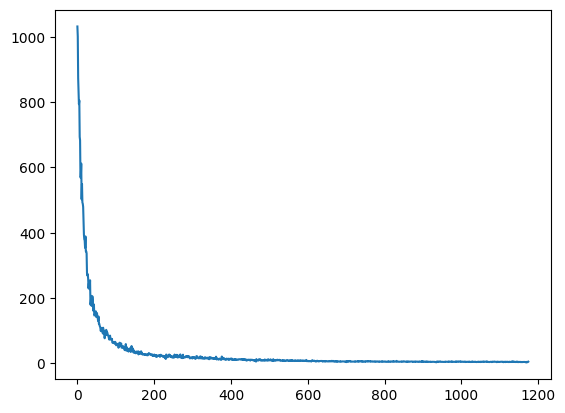

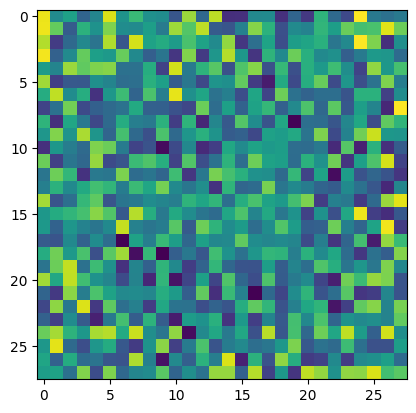

In [6]:
n_layers = 4
model = CobwebNN(n_layers=n_layers, branch_factor=2, n_hidden=784, 
                 n_classes=10, do_reprerentation_learning=False)
# model = CobwebSparse(n_layers=n_layers, branch_factor=2, n_input=64).to('cuda')

model.to('cuda')
optimizer = optim.Adam(model.parameters(), lr=3e-3)

untils.train_model(model, mnist_train, True, optimizer, epochs=5, batch_size=256, show_loss=True, 
                   device='cuda', verbose=False, early_break=False)
# display root_mean in matplotlib
root_mean = model.root_mean.cpu().detach().numpy().reshape(28, 28)
plt.imshow(root_mean)
plt.show()

In [7]:
untils.test_model(model, mnist_test, device='cuda', batch_size=256)

AttributeError: 'NoneType' object has no attribute 'argmax'

 12%|█▎        | 1/8 [00:00<00:00, 81.20it/s]


parent_mse: 18164.35546875
parent_mse: 9082.177734375
parent_mse: 18210.01953125
parent_mse: 9105.009765625


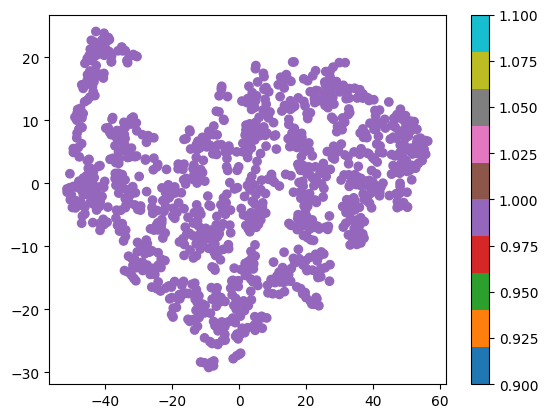

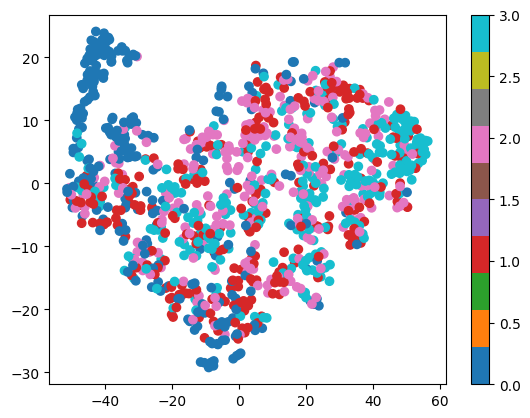

In [43]:
untils.visualize_decision_boundary(model, mnist_test_9_7, layer=0, n_hidden=64)

  5%|▌         | 1/20 [00:00<00:01,  9.94it/s]


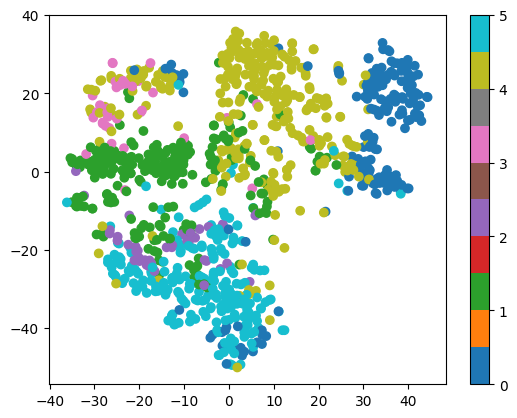

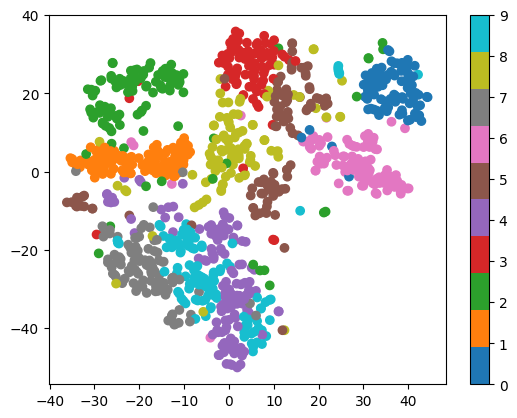

In [7]:
untils.visualize_decision_boundary(model, mnist_test, layer=2, n_hidden=784)